# Sistema de recomendaciones LicitaLAB
#### Basado en las descripciones de los usuarios y las categorías en que ofrecen.

Si es primera vez que se lanza este PyNotebook, se generarán un grupo de archivos, necesarios para llevar a cabo las recomendaciones. 

### Imports y configuraciones

In [1]:
import os
from utils.RecommenderSystem import RecommenderSystem  
import pandas as pd
from unidecode import unidecode 
from tqdm import tqdm
import torch 

if torch.cuda.is_available():
    # Set the GPU device (assuming you have at least one GPU)
    gpu_device = 0  # You can change this to the index of the GPU you want to use
    torch.cuda.set_device(gpu_device)
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(gpu_device)}")
else:
    # If no GPU is available, use the CPU
    device = torch.device("cpu")
    print("No GPU available, using CPU")


Using GPU: NVIDIA GeForce RTX 3060


Agregar la ubicación donde se encuentra el .csv con el que se genera el espacio de usuarios.

In [2]:
CSV_PATH = 'C:\\Users\\magda\\OneDrive\\Escritorio\\MDS_licitalab\\query_final_results_20231026023937.csv'

Carga el Dataset.

In [3]:
print("Counting length of csv file")
with open(CSV_PATH, 'r', encoding='utf-8') as file:
   total_lines = sum(1 for _ in file)
print(f"{total_lines} rows will be loaded to create the recommendation system")


Counting length of csv file
34761793 rows will be loaded to create the recommendation system


In [4]:
#total_lines = 500000
# Create an empty list to store the DataFrames from chunks
dfs = [] 
# Create a tqdm wrapper for pd.read_csv
with tqdm(total=total_lines, desc = 'Loading Dataset') as pbar:
    def update_progress(n):
        pbar.update(n)
    
    # Read the CSV file using pd.read_csv and provide the progress callback
    df_chunks = pd.read_csv(CSV_PATH, chunksize=50000, iterator=True, encoding='utf-8', nrows=total_lines)  # Specify the encoding
    for chunk in df_chunks:
        # Process each chunk if needed
        # You can access the chunk data in the 'chunk' DataFrame
        
        chunk['feature_vector'] = chunk['agileoffereditemscategoriaofertada'] + ' ' + chunk['agileoffereditemsdescripcionofertada']
        chunk['feature_vector'] = chunk['feature_vector'].apply(lambda x: unidecode(str(x)).lower())
        dfs.append(chunk)
        update_progress(chunk.shape[0])
        
df = pd.concat(dfs, ignore_index=True)

Loading Dataset:  44%|████▍     | 15301056/34761793 [06:09<07:49, 41409.62it/s]


(-200.0, 200.0)

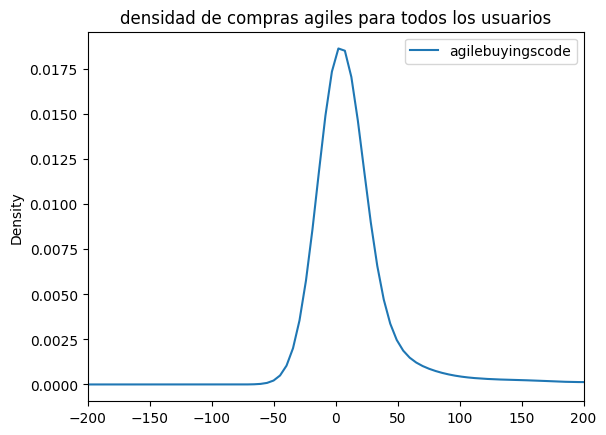

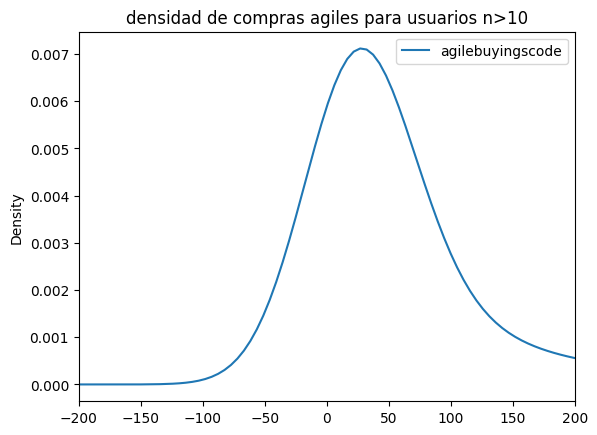

In [5]:
gb = df.groupby(by =['taxnumberprovider']).agg({'agilebuyingscode':'nunique'})
gb = gb.sort_values(by = 'agilebuyingscode')
ax = gb.plot.density(title = "densidad de compras agiles para todos los usuarios")
ax.set_xlim(-200, 200) 
n_strings = 10
qualifying_users =  gb[gb['agilebuyingscode'] >= n_strings]
ax =qualifying_users.plot.density(title = 'densidad de compras agiles para usuarios n>10')
ax.set_xlim(-200, 200) 

Lanzar el recomendador. Si no encuentra los archivos necesarios iniciará un proceso de generación de estos. Se demora bastante, pero no deberían haber problemas.

Initializing Recommender System
The current directory is c:\Users\magda\OneDrive\Escritorio\MDS_licitalab\Modeling\hito_4
Using GPU: NVIDIA GeForce RTX 3060
Models and Dataframes not found, initializing a Recommender System from zero.
Se han removido 72.83% de taxnumberproviders, por tener < 10 licitaciones. 
 El numero de usuarios para crear el corpus será 1846.


Selecting strings from each user: 100%|██████████| 1846/1846 [06:15<00:00,  4.91it/s]
Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at d

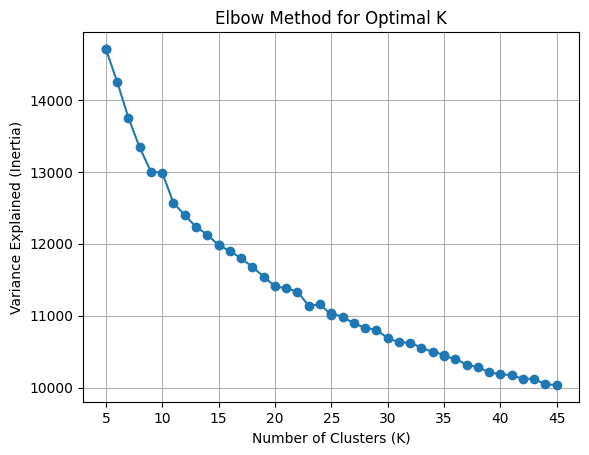

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Optimal n_clusters is 7


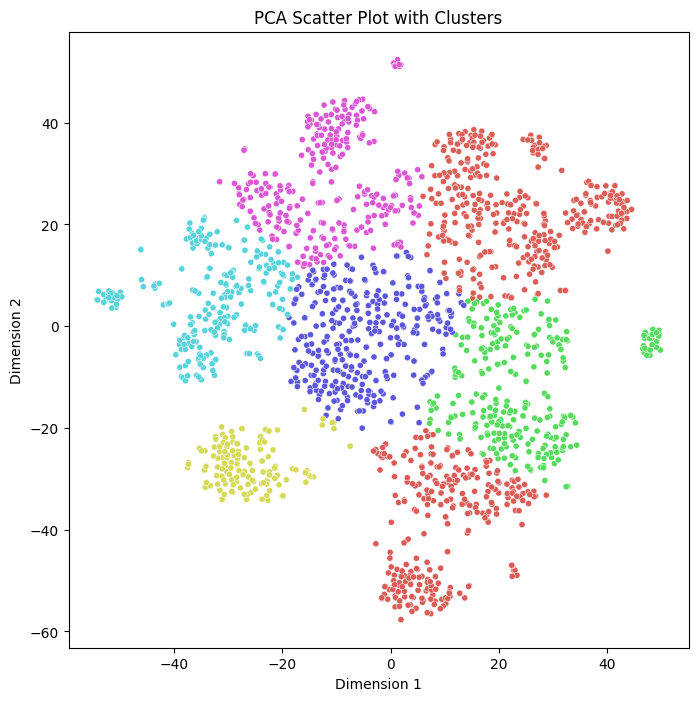

Exporting Kmeans model
Exporting Kmeans clusters
Exporting vectorizer model
Done
Exporting vectorized corpus


In [6]:
RS = RecommenderSystem(df,save_path=  os.getcwd())

### Predecir recomendaciones

Se le entrega el string del rut al sistema recomendador a traves de la función `predict()`. El sistema retorna el número de cluster al que el usuario ha sido asignado y un dataframe con las compras ágiles recomendadas. 

In [7]:
ruts = df['taxnumberprovider'].sample(n =1) 
n_cluster,gg = RS.predict(ruts.values[0])

(96.556.940-5) data point belongs to cluster 4


Agregando un poco de post-procesamiento se pueden encontrar visualizaciones de interés.

In [8]:
gg.query(f"Cluster == {n_cluster}")

,organismosolicitante,agilebuyingscode,agilebuyingsdescription,agilebuyingsstatus,agilebuyingscurrency,agilebuyingsavailableamount,agileitemsname,agileitemsmp_id,agileitemsproductcategory,agileoffereditemsproductoofertado,agileoffereditemscategoriaofertada,agileoffereditemsdescripcionofertada,agileoffereditemspreciototal,taxnumberprovider,provideractivity,adjudicada,feature_vector_x,feature_vector_y,Cluster
68,61.004.087-K,1968-203-COT23,"""AL MOMENTO DE ENVIAR COTIZACIÓN A TRAVÉS DE L...",OC Emitida,$,500000.0,Bolsas de basura,47121701,Equipos y suministros de limpieza / Equipo de ...,Bolsas de basura,Equipos y suministros de limpieza / Equipo de ...,"PRODUCTOS ENTREGADOS EN DIRECCION INDICADA, SI...",42015.0,76.373.318-1,SERVICIO DE BANQUETERIA,True,equipos y suministros de limpieza / equipo de ...,equipos y suministros de limpieza / equipo de ...,4.0
69,61.004.087-K,1968-203-COT23,"""AL MOMENTO DE ENVIAR COTIZACIÓN A TRAVÉS DE L...",OC Emitida,$,500000.0,Bolsas de basura,47121701,Equipos y suministros de limpieza / Equipo de ...,Bolsas de basura,Equipos y suministros de limpieza / Equipo de ...,"PRODUCTOS ENTREGADOS EN DIRECCION INDICADA, SI...",42015.0,76.373.318-1,SERVICIO DE BANQUETERIA,True,equipos y suministros de limpieza / equipo de ...,equipos y suministros de limpieza / equipo de ...,4.0
70,61.004.087-K,1968-203-COT23,"""AL MOMENTO DE ENVIAR COTIZACIÓN A TRAVÉS DE L...",OC Emitida,$,500000.0,Bolsas de basura,47121701,Equipos y suministros de limpieza / Equipo de ...,Bolsas de basura,Equipos y suministros de limpieza / Equipo de ...,"PRODUCTOS ENTREGADOS EN DIRECCION INDICADA, SI...",42015.0,76.373.318-1,SERVICIO DE BANQUETERIA,True,equipos y suministros de limpieza / equipo de ...,equipos y suministros de limpieza / equipo de ...,4.0
71,61.004.087-K,1968-203-COT23,"""AL MOMENTO DE ENVIAR COTIZACIÓN A TRAVÉS DE L...",OC Emitida,$,500000.0,Bolsas de basura,47121701,Equipos y suministros de limpieza / Equipo de ...,Bolsas de basura,Equipos y suministros de limpieza / Equipo de ...,"PRODUCTOS ENTREGADOS EN DIRECCION INDICADA, SI...",42015.0,76.373.318-1,SERVICIO DE BANQUETERIA,True,equipos y suministros de limpieza / equipo de ...,equipos y suministros de limpieza / equipo de ...,4.0
72,61.004.087-K,1968-203-COT23,"""AL MOMENTO DE ENVIAR COTIZACIÓN A TRAVÉS DE L...",OC Emitida,$,500000.0,Bolsas de basura,47121701,Equipos y suministros de limpieza / Equipo de ...,Bolsas de basura,Equipos y suministros de limpieza / Equipo de ...,"PRODUCTOS ENTREGADOS EN DIRECCION INDICADA, SI...",42015.0,76.373.318-1,SERVICIO DE BANQUETERIA,True,equipos y suministros de limpieza / equipo de ...,equipos y suministros de limpieza / equipo de ...,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300955,61.980.070-2,1057535-56-COT23,COMPRA ALIMENTOS NO PERECIBLES PARA FUNCIONARI...,OC Emitida,$,1200000.0,Granos de Legumbres,50221001,"Alimentos, bebidas y tabaco / Cereales y Legum...",Granos de Legumbres,"Alimentos, bebidas y tabaco / Cereales y Legum...","Plazo de entrega 5 días, en recinto indicado e...",39980.0,76.075.976-7,"OBRAS MENORES EN CONSTRUCCION (CONTRATISTAS, A...",True,"alimentos, bebidas y tabaco / cereales y legum...","jaleas, gelatinas, mermeladas, pastas de untar...",4.0
15300956,61.980.070-2,1057535-56-COT23,COMPRA ALIMENTOS NO PERECIBLES PARA FUNCIONARI...,OC Emitida,$,1200000.0,Granos de Legumbres,50221001,"Alimentos, bebidas y tabaco / Cereales y Legum...",Granos de Legumbres,"Alimentos, bebidas y tabaco / Cereales y Legum...","Plazo de entrega 5 días, en recinto indicado e...",39980.0,76.075.976-7,"OBRAS MENORES EN CONSTRUCCION (CONTRATISTAS, A...",True,"alimentos, bebidas y tabaco / cereales y legum...","jaleas, gelatinas, mermeladas, pastas de untar...",4.0
15300957,61.980.070-2,1057535-56-COT23,COMPRA ALIMENTOS NO PERECIBLES PARA FUNCIONARI...,OC Emitida,$,1200000.0,Granos de Legumbres,50221001,"Alimentos, bebidas y tabaco / Cereales y Legum...",Granos de Legumbres,"Alimentos, beb

In [9]:
display(gg.query(f"Cluster == {n_cluster}").groupby(by =['taxnumberprovider','agilebuyingscode','agilebuyingsdescription','agileitemsproductcategory']).count())

organismosolicitante  \
taxnumberprovider agilebuyingscode  agilebuyingsdescription                            agileitemsproductcategory                                                  
10.365.318-5      1000813-146-COT23 SE REQUIERE COTIZAR LOS SIGUIENTES ELEMENTOS PA... Equipamiento y suministros médicos / Vestuario ...                    32   
                                                                                       Equipamiento y suministros médicos / Vestuario ...                    32   
                  1000813-160-COT23 SE REQUIERE COTIZAR ELEMENTOS DE ASEO E HIGIENE... Equipos y suministros de limpieza / Suministros...                   160   
                                                                                       Equipos y suministros de limpieza / Suministros...                    96   
                  1000813-208-COT23 SE REQUIERE COTIZAR MATERIALES Y ÚTILES DE ASEO... Equipos y suministros de limpieza / Equipo de l...                    64   
...                                                                                                                                                         ...   
99.571.800-6      2153-191-COT23    SERA OBLIGATORIO PRESENTAR EN SU OFERTA \n1.\tO... Equipos y suministros de limpieza / Equipo de l...                    64   
                  2412-309-COT23    Se requieren adquirir los artículos indicados e... Equipos y suministros de limpieza / Suministros...                    64   
                  2703-100-COT23    Materiales para uso en Cesfam Talagante insumos... Ropa, maletas y productos de aseo personal / Ro...                   128   
                  449-165-COT23     Pañales Babysec premium o similar, tallas media... Ropa, maletas y productos de aseo personal / Ro...                   192   
                  4848-122-COT23    SE SOLICITA COTIZACION PARA LA COMPRA DE HILO D... Ropa, maletas y productos de aseo personal / Ar...                    64   

                                                                                                                                           agilebuyingsstatus  \
taxnumberprovider agilebuyingscode  agilebuyingsdescription                            agileitemsproductcategory                                                
10.365.318-5      1000813-146-COT23 SE REQUIERE COTIZAR LOS SIGUIENTES ELEMENTOS PA... Equipamiento y suministros médicos / Vestuario ...                  32   
                                                                                       Equipamiento y suministros médicos / Vestuario ...                  32   
                  1000813-160-COT23 SE REQUIERE COTIZAR ELEMENTOS DE ASEO E HIGIENE... Equipos y suministros de limpieza / Suministros...                 160   
                                                                                       Equipos y suministros de limpieza / Suministros...                  96   
                  1000813-208-COT23 SE REQUIERE COTIZAR MATERIALES Y ÚTILES DE ASEO... Equipos y suministros de limpieza / Equipo de l...                  64   
...                                                                                                                                                       ...   
99.571.800-6      2153-191-COT23    SERA OBLIGATORIO PRESENTAR EN SU OFERTA \n1.\tO... Equipos y suministros de limpieza / Equipo de l...                  64   
                  2412-309-COT23    Se requieren adquirir los artículos indicados e... Equipos y suministros de limpieza / Suministros...                  64   
                  2703-100-COT23    Materiales para uso en Cesfam Talagante insumos... Ropa, maletas y productos de aseo personal / Ro...                 128   
                  449-165-COT23     Pañales Babysec premium o similar, tallas media... Ropa, maletas y productos de aseo personal / Ro...                 192   
                  4848-122-COT23    SE SOLICITA COTIZACION PARA LA COMPRA DE HILO D... 